In [71]:
%matplotlib inline
import matplotlib.pyplot as plt
import autograd.numpy as np

# add the data folder to path (this specifies a relative path to where my data is stored)
import os, sys

In [72]:
def rosenbrock(x):
    """ returns rosenbrock function evaluated at a specified input location. """
    assert np.ndim(x) == 2, "x must be 2d."
    assert (
        x.shape[0] >= 1 and x.shape[1] >= 2
    ), "must have a least n=1 training point and at least d=2 input dimensions"
    return np.sum(
        100.0 * np.square(x[:, 1:] - np.square(x[:, :-1])) + np.square(1.0 - x[:, :-1]),
        axis=1,
        keepdims=True,
    )

In [73]:
def forward_pass(x, W1, W2, b1, b2, phi1, phi2):
    """
    forward-pass for an MLP with a single hidden layer of M neurons
    Inputs:
        x : (N, 2) training inputs
        W1 : (M, 2) weights of first (hidden) layer
        W2 : (1, M) weights of second (output) layer
        b1 : (M, 1) biases of first (hidden) layer
        b2 : (1, 1) biases of second (output) layer
        phi1 : 1st layer activation function
        phi2 : 2nd layer activation function
    Outputs:
        Fhat : (N, 1) output of the neural network at training inputs
    """
    H1 = phi1(np.dot(x, W1.T) + b1.T) # layer 1 neurons, shape (N, M)
    Fhat = phi2(np.dot(H1, W2.T) + b2.T) # layer 2 neurons, shape (N, 1)
    return Fhat

In [74]:
#np.random.seed(0)
scale = 0.1 # standard deviation of initialization
M = 200 # number of neurons in hidden layer
n_param = 2*M + M + M + 1
W1 = scale * np.random.randn(M, 2)
W2 = scale * np.random.randn(1, M)
b1 = scale * np.random.randn(M, 1)
b2 = scale * np.random.randn(1, 1)
phi1 = lambda z: np.maximum(0., z) # relu on hidden layer
phi2 = lambda z: z # linear activation on output layer

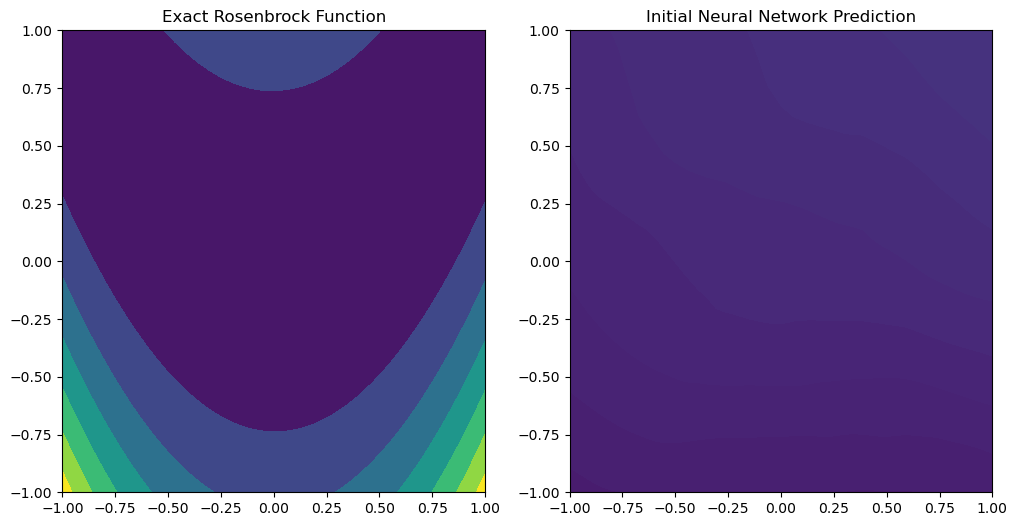

In [75]:
x_train = 2.*np.random.rand(1000, 2) - 1
y_train = rosenbrock(x_train)
y_train = (y_train - y_train.mean())/y_train.std() # transform training set to zero mean and unit variance

# get a grid to evaluate the exact rosenbrock function on
xx1, xx2 = np.meshgrid(np.linspace(-1,1,num=50), np.linspace(-1,1,num=50))
x_test = np.c_[xx1.flatten(), xx2.flatten()]
y_test = (rosenbrock(x_test).reshape((50,50)) - np.mean(rosenbrock(x_train)))/np.std(rosenbrock(x_train))

# plot
fig, axs = plt.subplots(ncols=2, figsize=(12,6))
axs[0].contourf(xx1, xx2, y_test, vmin=y_test.min(), vmax=y_test.max())
axs[0].set_title("Exact Rosenbrock Function")
axs[1].contourf(xx1, xx2, forward_pass(x_test, W1, W2, b1, b2, phi1, phi2).reshape((50,50)), 
                vmin=y_test.min(), vmax=y_test.max());
axs[1].set_title("Initial Neural Network Prediction");

In [76]:
def update_parameters(w, grad_w, learning_rate=1.):
    """
    perform gradient descent update to minimize an objective
    Inputs:
        w : vector of parameters
        grad_w : gradient of the loss with respect to the parameters
        learning_rate : learning rate of the optimizer
    """
    return w - learning_rate * grad_w


def least_squares_loss(W1, W2, b1, b2, phi1, phi2, x, y):
    """ compute the least squares loss for the MLP. The learnable parameters are the inputs. """
    return np.mean(np.square(forward_pass(x, W1, W2, b1, b2, phi1, phi2) - y))

In [77]:
from autograd import grad, hessian
least_squares_gradient = grad(least_squares_loss, argnum=[0,1,2,3])
W1_hessian = hessian(least_squares_loss, argnum=0)

In [78]:
learning_rate = 0.1
log_contvar = np.log(0.1)
n_samp = 2000

log_contvar_grad_reinforce = np.zeros((n_samp,))
log_contvar_grad_reparam = np.zeros((n_samp,))
log_contvar_hist = np.zeros((n_samp,))

for i in range(n_samp):
    log_contvar_hist[i] = log_contvar
    contvar = np.exp(log_contvar)

    eps_W1 = np.random.normal(size=W1.shape)
    eps_W2 = np.random.normal(size=W2.shape)
    eps_b1 = np.random.normal(size=b1.shape)
    eps_b2 = np.random.normal(size=b2.shape)
    
    W1_perturb = W1 - np.sqrt(contvar)*eps_W1
    W2_perturb = W2 - np.sqrt(contvar)*eps_W2
    b1_perturb = b1 - np.sqrt(contvar)*eps_b1
    b2_perturb = b2 - np.sqrt(contvar)*eps_b2

    # compute the gradient
    loss = least_squares_loss(W1_perturb, W2_perturb, b1_perturb, b2_perturb, phi1, phi2, x_train, y_train)
    W1_grad, W2_grad, b1_grad, b2_grad = least_squares_gradient(W1_perturb, W2_perturb, b1_perturb, b2_perturb, phi1, phi2, x_train, y_train)

    log_contvar_grad_reinforce[i] = (np.sum(np.square(eps_W1)) + np.sum(np.square(eps_W2)) + np.sum(np.square(eps_b1)) + np.sum(np.square(eps_b2)) - n_param)/2
    log_contvar_grad_reparam[i] = -(np.sum(W1_grad*eps_W1) + np.sum(W2_grad*eps_W2) + np.sum(b1_grad*eps_b1) + np.sum(b2_grad*eps_b2))*np.sqrt(contvar)/2

    # update the parameters
    
    W1 = update_parameters(W1, W1_grad, learning_rate)
    W2 = update_parameters(W2, W2_grad, learning_rate)
    b1 = update_parameters(b1, b1_grad, learning_rate)
    b2 = update_parameters(b2, b2_grad, learning_rate)
    log_contvar = update_parameters(log_contvar, log_contvar_grad_reparam[i], learning_rate)
    # print loss if nessessary
    if i==0 or (i+1) % 200 == 0:
        print("Iter %3d, loss = %.6f" % (i+1, least_squares_loss(W1, W2, b1, b2, phi1, phi2, x_train, y_train)))

Iter   1, loss = 1.118122
Iter 200, loss = 0.131520
Iter 400, loss = 0.066998
Iter 600, loss = 0.054815
Iter 800, loss = 0.034481
Iter 1000, loss = 0.032102
Iter 1200, loss = 0.017235
Iter 1400, loss = 0.011567
Iter 1600, loss = 0.009687
Iter 1800, loss = 0.007040
Iter 2000, loss = 0.005432


Text(0.5, 1.0, 'log contvar grad')

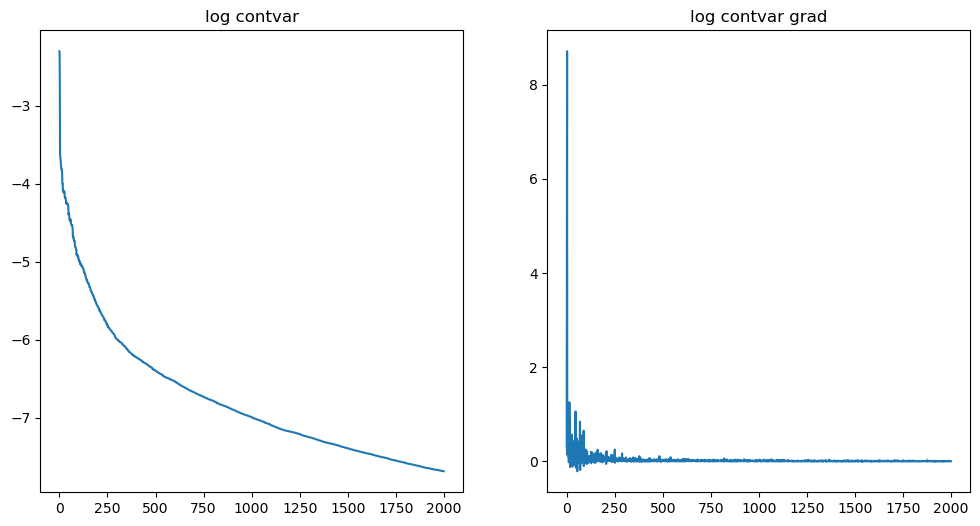

In [79]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6))
#axs[0].hist(log_contvar_grad_reinforce, bins=50)
#axs[1].hist(log_contvar_grad_reparam, bins=50)
#print(np.mean(log_contvar_grad_reinforce), '+-', 3*np.sqrt(np.var(log_contvar_grad_reinforce)/n_samp))
#print(np.mean(log_contvar_grad_reparam), '+-', 3*np.sqrt(np.var(log_contvar_grad_reparam)/n_samp))
axs[0].plot(np.arange(n_samp), log_contvar_hist)
axs[0].set_title("log contvar")
axs[1].plot(np.arange(n_samp), log_contvar_grad_reparam)
axs[1].set_title("log contvar grad")

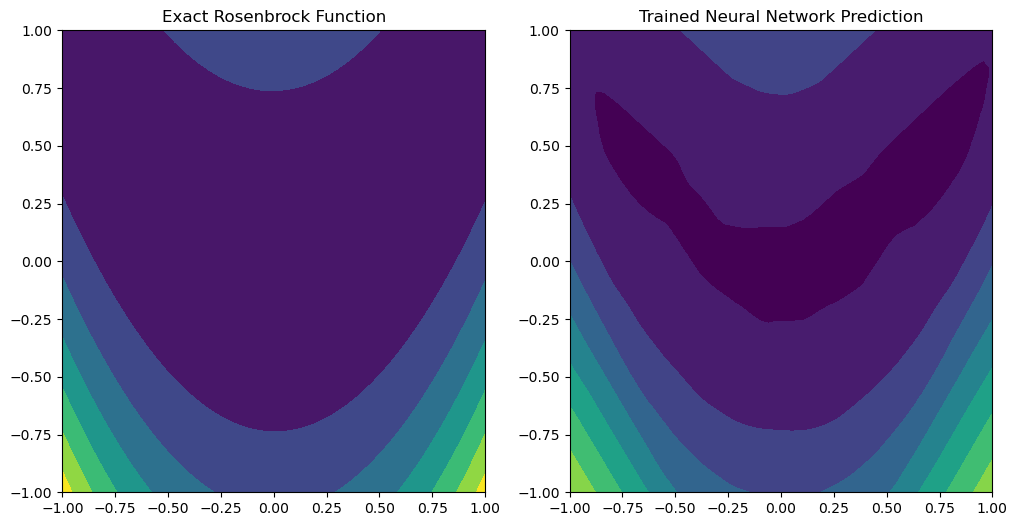

In [80]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6))
axs[0].contourf(xx1, xx2, y_test, vmin=y_test.min(), vmax=y_test.max())
axs[0].set_title("Exact Rosenbrock Function")
axs[1].contourf(xx1, xx2, forward_pass(x_test, W1, W2, b1, b2, phi1, phi2).reshape((50,50)),
                vmin=y_test.min(), vmax=y_test.max());
axs[1].set_title("Trained Neural Network Prediction");